In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('darkgrid')
from collections import Counter

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

# Modeling
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from numpy import argmax

In [2]:
!pwd

/home/yon/Documents/Personal_Plan/Project_3_ChurnRatePrediction/projectChurnRate


Datasets:
* Dataset pre-processed: ./Data/df_preprocess_done.csv
* Dataset for prediction: ./Data/df_prediction.csv'

In [2]:
df = pd.read_csv('./Data/df_preprocess_done.csv', index_col=0)
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head()

Size of the dataset:  20105
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
59394,1,21.0,na,0,0,1,0,1,Bi-Weekly,Aquarius,0,0,0.00,0
50931,1,28.0,na,0,8,1,1,1,Weekly,Aquarius,0,0,1.03,0
28738,0,27.0,R,65,4,1,0,0,na,Scorpio,0,1,2.20,1
55968,0,44.0,na,0,0,1,1,1,Monthly,Aquarius,0,0,0.00,0
50686,1,39.0,O,0,6,1,1,0,Bi-Weekly,Capricorn,0,0,0.40,1


# 4. Modeling

1. Separate dataset 
    - for X and y classes. 
    - Split dataset for training and testing.
2. Pipeline for transformation
    - Num-Val: Normalize data for training
    - Cat-Val: One hot encoding
3. Find the best parameters of the model
    - Use linear model
    - Use a tool
4. Modeling for finding the best:
    - Model creation with pipeline
    - GridSearchCV for finding the best parameters of each model
    - Model Calibration using best parameters



In [ ]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score", "elapsed_time"])

## 1. Separate dataset for X and y classes.

In [4]:
X = df.drop('churn', axis = 1)
y = df['churn']
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))


X shape: (20105, 13)
y shape: (20105,)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (14073, 13)
y_train shape: (14073,)
x_test shape: (6032, 13)
y_test shape: (6032,)


In [15]:
x_train.columns

Index(['age', 'housing', 'purchases_partners', 'cc_application_begin',
       'app_downloaded', 'web_user', 'android_user', 'payment_type',
       'zodiac_sign', 'left_for_two_month_plus', 'left_for_one_month',
       'reward_rate', 'is_referred'],
      dtype='object')

## 2. Pipeline for transformation
* Num-Val: Normalize data for training
* Cat-Val: One hot encoding

In [6]:
# Update numerical and categorical values for later modeling. Without consider churn variable

cat_features = df.select_dtypes(exclude = np.number).columns
num_features = df.select_dtypes(include = np.number).columns
num_features = num_features[1:]
print( "Quantity of Categorical features: ", len(cat_features),"\nCategorical features: ", cat_features)
print( "\nQuantity of Numerical features: ", len(num_features),"\nNumerical features: ", num_features)

Quantity of Categorical features:  3 
Categorical features:  Index(['housing', 'payment_type', 'zodiac_sign'], dtype='object')

Quantity of Numerical features:  10 
Numerical features:  Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
       'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dtype='object')


In [7]:
# Pipeline:

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])	

churn_trans = ColumnTransformer( transformers=[  ('numerical', num_transformer, num_features)  ,('categorical', cat_transformer, cat_features)])

In [8]:
# Parameters that pipeline can accepts:

num_transformer.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'imputer', 'scaler', 'imputer__add_indicator', 'imputer__copy', 'imputer__fill_value', 'imputer__missing_values', 'imputer__strategy', 'imputer__verbose', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std'])

In [38]:
x_train_transformed = churn_trans.fit(x_train).get_feature_names_out
x_test_transformed = churn_trans.fit_transform(x_test)
x_train_transformed

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
       'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['hou

TypeError: 'method' object is not subscriptable

## 3. Find the best parameters of the model
- Use linear model
- Use a tool

## 4. Modeling for finding the best:
- Model creation with pipeline
- GridSearchCV for finding the best parameters of each model
- Model Calibration using best parameters

### 4.1 Logistic Regresion Model

In [10]:
# Logistic Regresion Model

logr_model = LogisticRegression();
churn_pipe_logr = Pipeline(steps = [('prep', churn_trans), ('clas',logr_model)])

In [21]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['prep__numerical__imputer__strategy'] = ['mean', 'median']
#parameters['clas__C'] = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
parameters['clas__C'] = np.logspace(-3,3,10) 
parameters['clas__class_weight'] = [None, 'balanced']
parameters['clas__penalty'] = ["l1","l2",'elasticnet']
parameters['clas__solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag']


GS = GridSearchCV(churn_pipe_logr, parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
       'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dty...
             param_grid={'clas__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e

In [22]:
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

churn_pipe_logr = GS.best_estimator_

Mejor score:  0.5951338842987538
Mejor configuración de parámetros:  {'clas__C': 0.001, 'clas__class_weight': None, 'clas__penalty': 'l2', 'clas__solver': 'newton-cg', 'prep__numerical__imputer__strategy': 'mean'}


In [142]:
#building a dataframe from cross-validation data
#df_cv_scores=pd.DataFrame(GS.cv_results_).sort_values(by='rank_test_score')
df_cv_scores=pd.DataFrame(GS.cv_results_)
print(df_cv_scores.columns)
df_cv_scores.head()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clas__C', 'param_clas__class_weight', 'param_clas__penalty',
       'param_prep__numerical__imputer__strategy', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clas__C,param_clas__class_weight,param_clas__penalty,param_prep__numerical__imputer__strategy,params,split0_test_accuracy,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.078219,0.097963,0.000000,0.000000,0.001,None,l1,mean,"{'clas__C': 0.001, 'clas__class_weight': None,...",NaN,...,NaN,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
1,0.022117,0.001018,0.000000,0.000000,0.001,None,l1,median,"{'clas__C': 0.001, 'clas__class_weight': None,...",NaN,...,NaN,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93
2,0.085987,0.090639,0.012811,0.000615,0.001,None,l2,mean,"{'clas__C': 0.001, 'clas__class_weight': None,...",0.634103,...,0.010338,1,0.489157,0.479133,0.470305,0.473896,0.477912,0.47808,0.006353,39
3,0.047234,0.001551,0.012871,0.000217,0.001,None,l2,median,"{'clas__C': 0.001, 'clas__class_weight': None,...",0.634103,...,0.010338,1,0.489157,0.479133,0.470305,0.473896,0.477912,0.47808,0.006353,39
4,0.024262,0.001221,0.000000,0.000000,0.001,None,elasticnet,mean,"{'clas__C': 0.001, 'clas__class_weight': None,...",NaN,...,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92


In [ ]:
#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()

In [13]:

def show_results(y, y_pred):
    from sklearn.metrics import confusion_matrix


    # COMPLETAR
    c_mat = confusion_matrix(y, y_pred)


    sns.heatmap(c_mat, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados: ")
    print(f'\taccuracy: { accuracy_score(y, y_pred) :.3f}')
    print(f'\trecall: { recall_score(y, y_pred, average="macro") :.3f}')
    print(f'\tprecision: { precision_score(y, y_pred, average="macro") :.3f}')
    print(f'\tf1_score: { f1_score(y, y_pred, average="macro") :.3f}')

In [23]:
#checking how well the model does on the holdout-set
GS.score(x_test,y_test)

0.5818264014466547

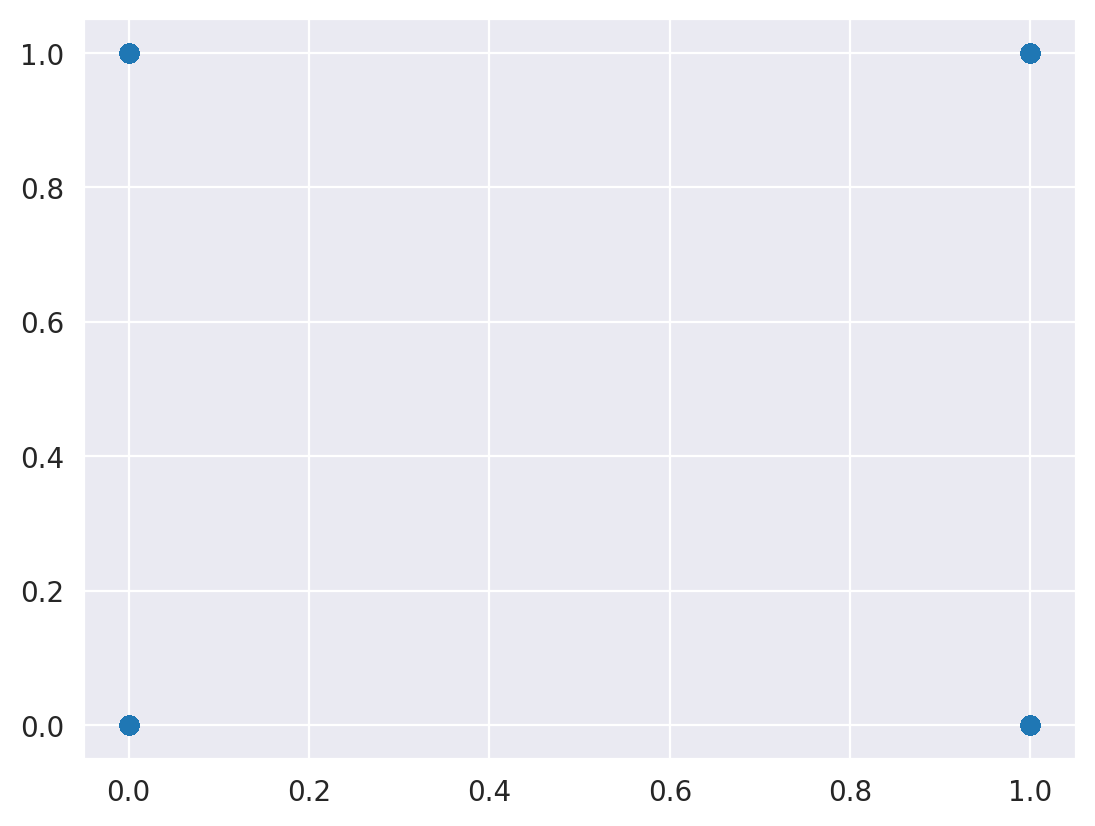

In [24]:
#plotting predicted body weights vs actual body weights of penguins
y_preds=GS.predict(x_test)
plt.scatter(y_test,y_preds);

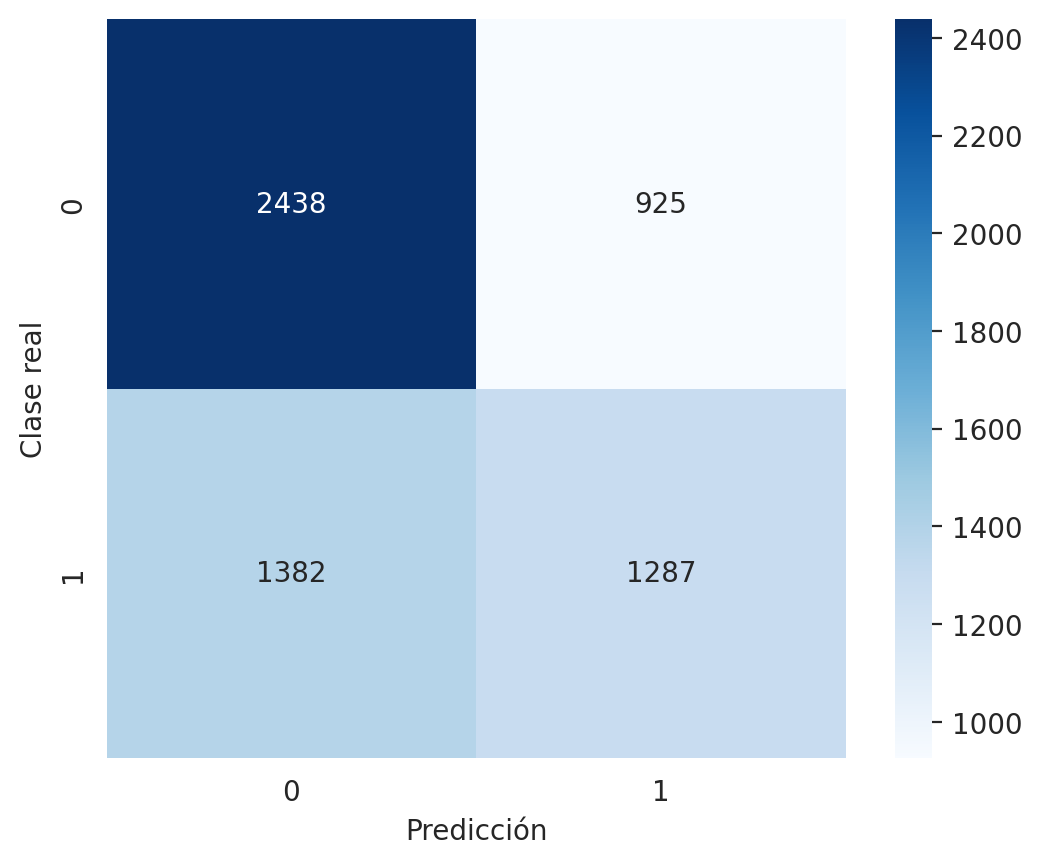

Resultados: 
	accuracy: 0.618
	recall: 0.604
	precision: 0.610
	f1_score: 0.603


In [26]:
y_pred = GS.predict(x_test)
show_results(y_test, y_pred)


In [27]:
y_prob = churn_pipe_logr.predict_proba(X)[:,1]

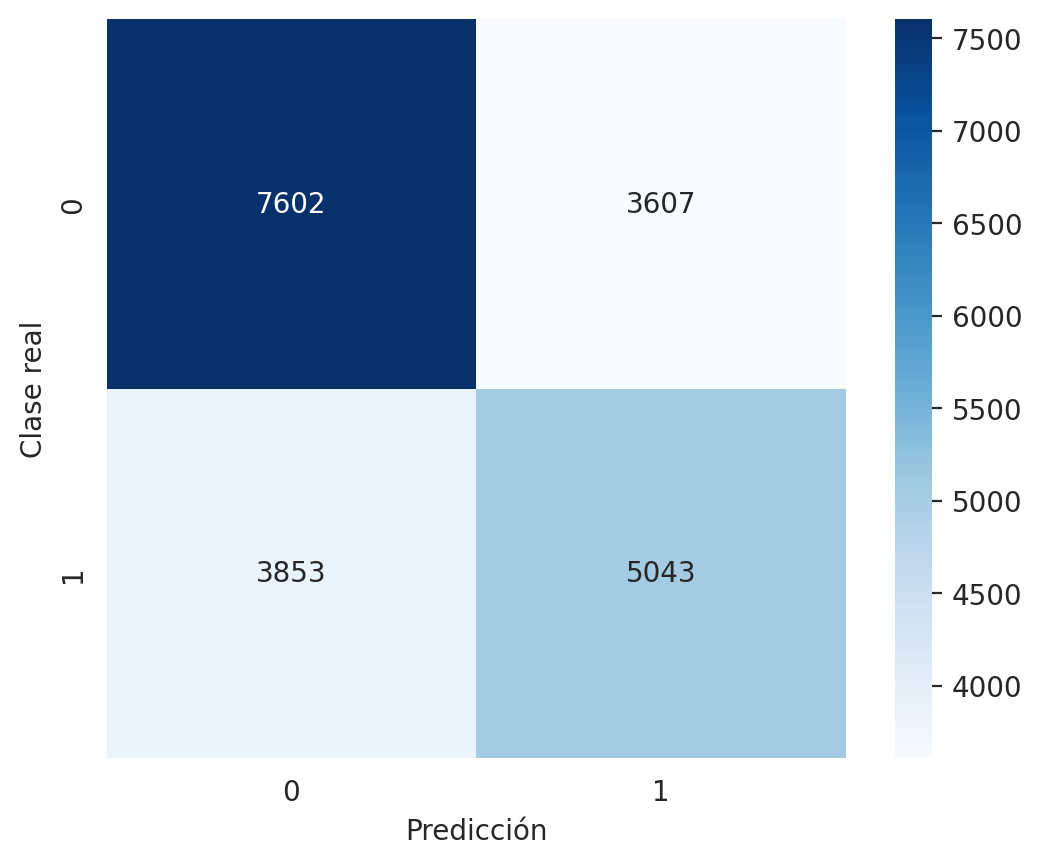

Resultados: 
	accuracy: 0.629
	recall: 0.623
	precision: 0.623
	f1_score: 0.623


In [28]:
y_pred = y_prob >= 0.48
show_results(y, y_pred)

Best Threshold=0.374921, F-Score=0.640
Umbrales considerados: 		 [0.1236 0.127  0.1271 ... 0.7008 0.7009 0.7052]
Predicciones (valores únicos):   [0.0931 0.1057 0.1086 ... 0.7008 0.7009 0.7052]


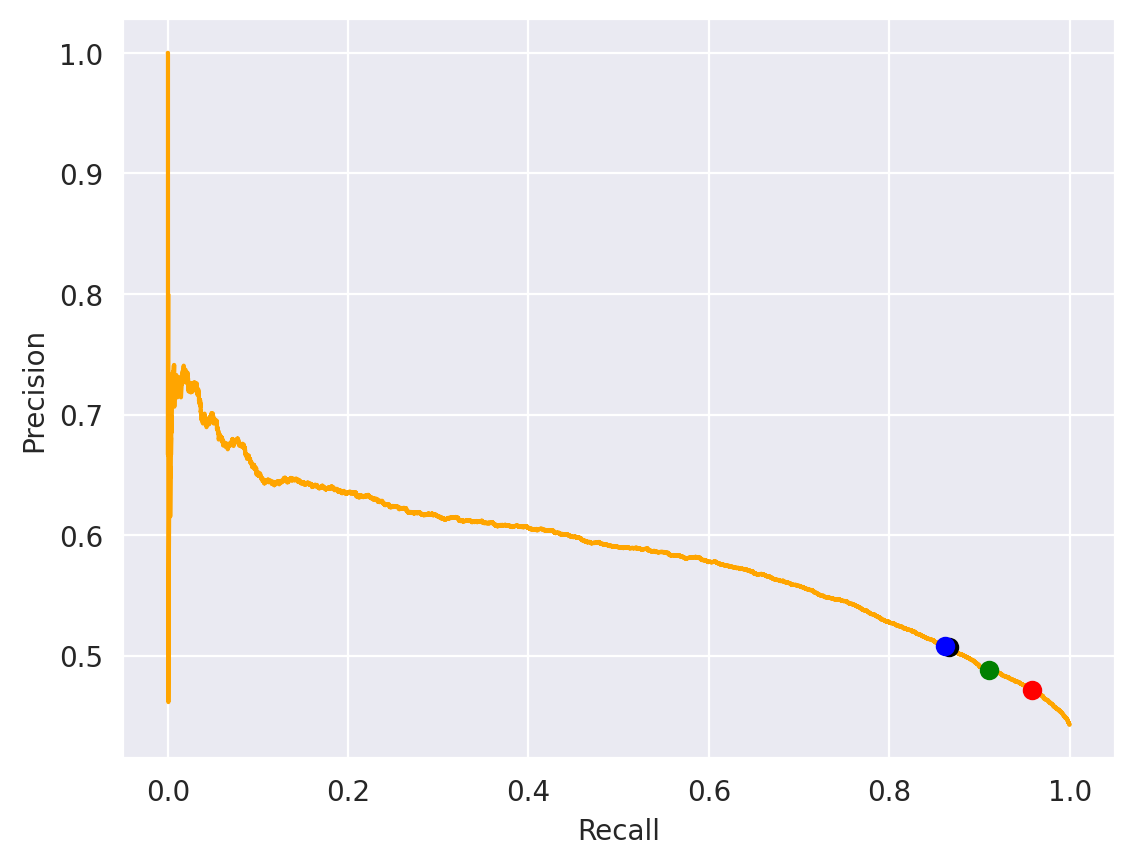

In [19]:
# COMPLETAR

precision, recall, thresholds = precision_recall_curve(y, y_prob)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, color='orange')
plt.plot(recall[ix],precision[ix], marker='o', color='black'); # mejor threshold


plt.plot(recall[2000],precision[2000], 'or'); # Umbral = 0.227, rojo
plt.plot(recall[3500],precision[3500], 'og'); # Umbral = 0.5, verde
plt.plot(recall[5000],precision[5000], 'ob'); # Umbral = 0.805, azul
plt.xlabel('Recall')
plt.ylabel('Precision');

print("Umbrales considerados: \t\t", np.round(thresholds,4))
print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

In [20]:
argmax(fscore), thresholds

(4896,
 array([0.12355507, 0.12698987, 0.12712489, ..., 0.70083956, 0.70090752,
        0.70518065]))

### 4.1 Decision Tree Model

Mejor score:  0.6433930645864024
Mejor configuración de parámetros:  {'clas__class_weight': None, 'clas__max_depth': 5, 'prep__numerical__imputer__strategy': 'mean'}


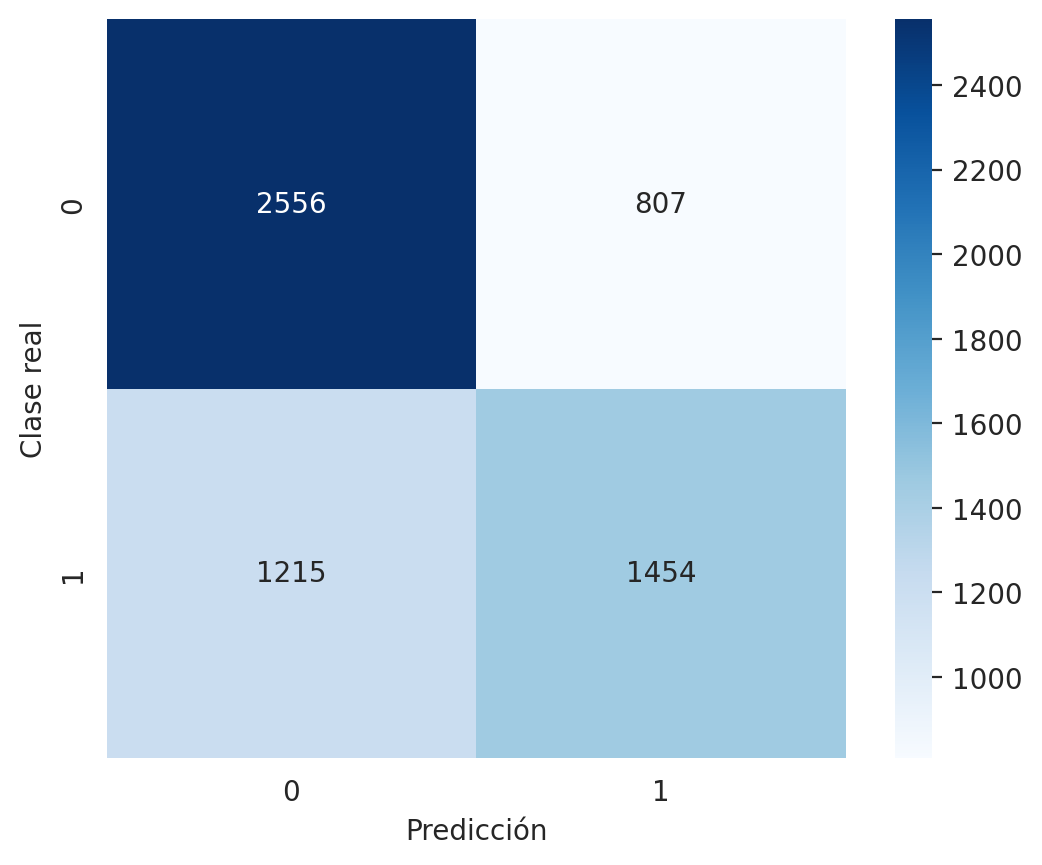

Resultados: 
	accuracy: 0.665
	recall: 0.652
	precision: 0.660
	f1_score: 0.653


In [77]:
dt_model = DecisionTreeClassifier();


# COMPLETAR
churn_pipe_tree = Pipeline(steps = [('prep', churn_trans), ('clas',dt_model)])


parameters = {}
parameters['prep__numerical__imputer__strategy'] = ['mean', 'median']
parameters['clas__max_depth'] = [None, 3, 5, 7, 9]
parameters['clas__class_weight'] = [None, 'balanced']


#
# COMPLETAR
#
GS = GridSearchCV(churn_pipe_tree, parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)

print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

churn_pipe_tree = GS.best_estimator_

#
# COMPLETAR
#
y_pred = GS.predict(x_test)
show_results(y_test, y_pred)

In [78]:
y_prob = churn_pipe_tree.predict_proba(x_test)[:,1]

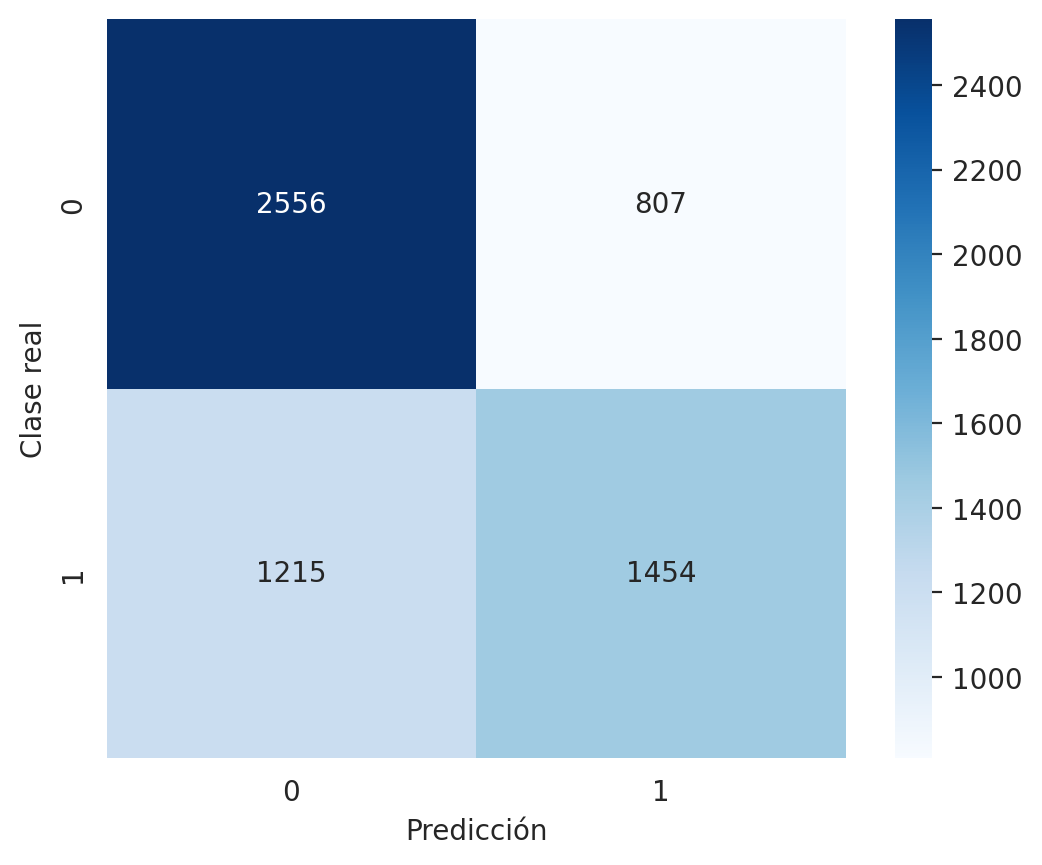

Resultados: 
	accuracy: 0.665
	recall: 0.652
	precision: 0.660
	f1_score: 0.653


In [84]:
y_pred = y_prob >= 0.47
show_results(y_test, y_pred)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, color='orange')
plt.plot(recall[ix],precision[ix], marker='o', color='black'); # mejor threshold


plt.xlabel('Recall')
plt.ylabel('Precision');

print("Umbrales considerados: \t\t", np.round(thresholds,4))
#print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

In [90]:
 thresholds

array([False,  True])

### 4.3. SVM Model

In [ ]:

svm_model = SVC(probability=True);


# COMPLETAR
churn_pipe_svc = Pipeline(steps = [('prep', churn_trans), ('clas',svm_model)])


parameters = {}
parameters['prep__numerical__imputer__strategy'] = ['mean', 'median']
parameters['clas__C'] = [10e-2, 1, 100]
parameters['clas__kernel'] = ['linear', 'rbf']


#
# COMPLETAR
#
GS = GridSearchCV(churn_pipe_svc, parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)


print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

churn_pipe_svc = GS.best_estimator_

#
# COMPLETAR
#
y_pred = GS.predict(x_test)
show_results(y_test, y_pred)
